### Compute vorticity from altimetry SSH and velocity fields from NISKINe moorings

In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import gsw
import metpy
from pathlib import Path
import cartopy.crs as ccrs
import geopy.distance
import mplniw.utils as ut
import mplniw.sigp as sp
import matplotlib.gridspec as gridspec

import gvpy as gv

import niskine
from datetime import datetime

In [2]:

root_dir = '/Users/zcasparcohen/codes/NIW/data/' # directory

#Load coordinates and seafloor depth for all moorings
conf = niskine.io.load_config()
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)


In [3]:
f = gv.ocean.inertial_frequency(m1lat) #Coriolis frequency at mooring M1 location

In [34]:
topo = xr.open_dataset('/Users/zcasparcohen/Downloads/ETOPO_2022_v1_30s_N90W180_bed.nc').z.sel(lon=slice(-30,-15.3),lat=slice(55,64.8))
topo = topo.isel(lon=slice(0,None,1),lat=slice(0,None,1))

In [4]:
# Load altimetry data
alt = niskine.io.load_ssh() #ssh and geostrophy fields
alt['eke'] = 1/2 * (alt.ugosa**2 + alt.vgosa**2) #eke from altimetry
eke = alt.eke.sel(time=slice('2009-01-01',None))  #EKE subset
_time = eke.time #time from eke subset

In [5]:
#Computing vorticity from altimetry
vort = metpy.calc.vorticity(alt.ugosa, alt.vgosa) 
vort = vort.metpy.dequantify()
vort = vort / f  #normailized relative vorticity
vort.attrs = dict(long_name='$\zeta / f$', units='') #adding name to xarray attributes

In [6]:
#Saving dataset (change False to True)
if False:
    vort.to_netcdf(root_dir+'vort_alt_long.nc')

### Visualizing and analysing the evolution of relative vorticity in Iceland Basin: averaged values and repartition of anticyclonic/cyclonic circulation

(<matplotlib.patches.Rectangle at 0x15f282b10>,
 (<matplotlib.patches.ConnectionPatch at 0x15f2b7c90>,
  <matplotlib.patches.ConnectionPatch at 0x15f2e78d0>))

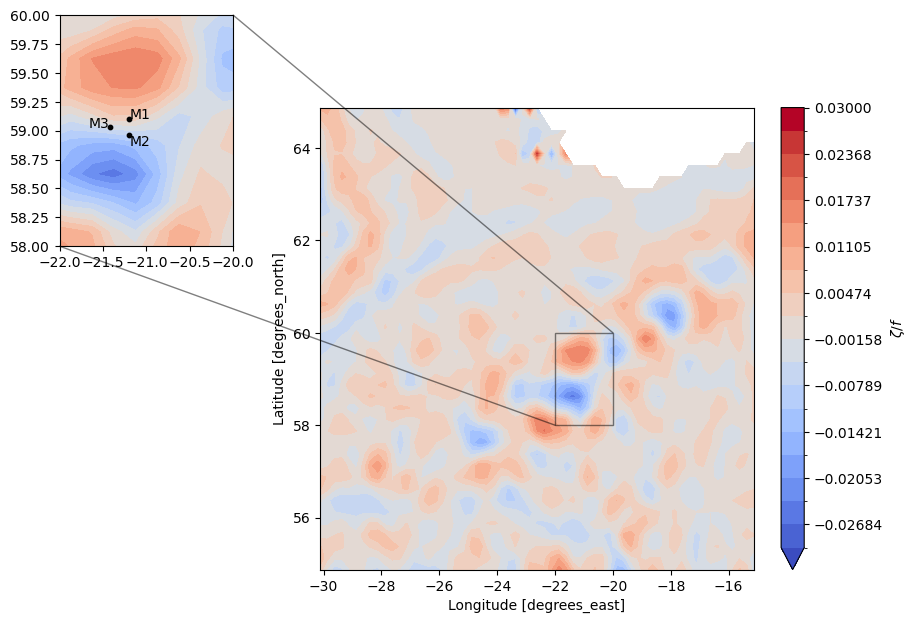

In [7]:
#Surface relative vorticity from altimetry in Iceland Basin
fig,ax = plt.subplots(figsize=(7,6))
vort.mean('time').plot.contourf(ax=ax,cmap='coolwarm',levels=20,vmin=-0.03,vmax=0.03,cbar_kwargs={'label':r'$\zeta /f $'})
#ax.scatter(m1lon,m1lat,s=2);ax.scatter(m2lon,m2lat,s=2);ax.scatter(m3lon,m3lat,s=2)
axins = ax.inset_axes([-0.6, 0.7, 0.4, 0.5])
vort.mean('time').plot.contourf(ax=axins,cmap='coolwarm',levels=20,vmax=0.03,add_colorbar=False)
axins.set_xlim((-22),(-20))
axins.set_ylim((58),(60))
axins.scatter(m1lon,m1lat,s=10,c='k');axins.scatter(m2lon,m2lat,s=10,c='k');axins.scatter(m3lon,m3lat,s=10,c='k')
axins.set_ylabel('');axins.set_xlabel('')
axins.text(m1lon,m1lat,'M1');axins.text(m2lon,m2lat-0.1,'M2');axins.text(m3lon-0.25,m3lat,'M3')
ax.indicate_inset_zoom(axins,edgecolor='black')

Notes: The averaged vorticity field shows that the moorings are located in an area ofenhanced vorticity. For an averege over 14 years used here, the moorings are located in different area of vorticity. M1 is on the edge of a cyclone, M2 on the edge of a anticyclone and M3 in an neutral area. Obviously this is a remark made on an average over more than a decade. When analysing statistics over shorter time preiod the effect of this distribution of the mooring should not appear.

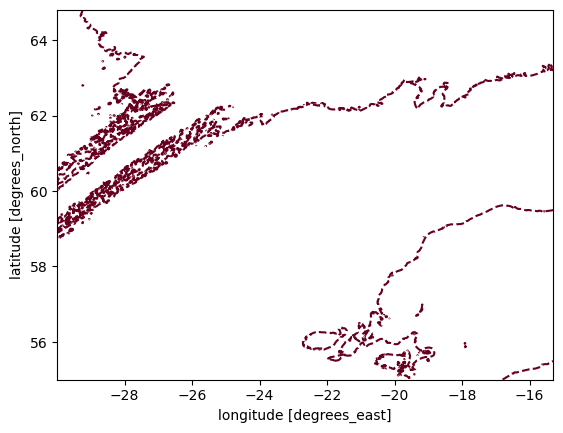

In [36]:
topo.plot.contour(levels=[-1500])

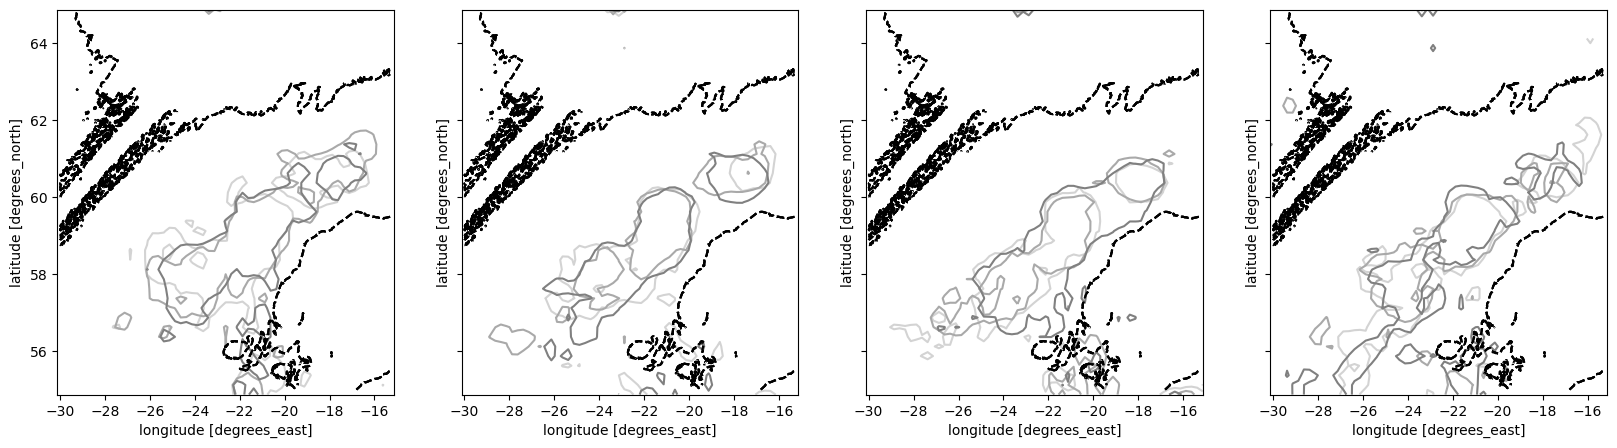

In [40]:
#alt.eke.groupby("time.year").mean().sel(year=2012).plot()
fig,axs=plt.subplots(1,4,figsize=(20,5),sharey=True)
ax=axs[0]
for c,y in zip(['lightgrey','darkgrey','grey'],np.arange(2005,2009)):
    alt.eke.groupby("time.year").mean().sel(year=y).plot.contour(levels=[0.015],colors=c,ax=ax)
    topo.plot.contour(levels=[-1500],ax=ax,colors='k')
ax=axs[1]
for c,y in zip(['lightgrey','darkgrey','grey'],np.arange(2009,2013)):
    alt.eke.groupby("time.year").mean().sel(year=y).plot.contour(levels=[0.015],colors=c,ax=ax)
    topo.plot.contour(levels=[-1500],ax=ax,colors='k')
ax=axs[2]
for c,y in zip(['lightgrey','darkgrey','grey'],np.arange(2013,2017)):
    alt.eke.groupby("time.year").mean().sel(year=y).plot.contour(levels=[0.015],colors=c,ax=ax)
    topo.plot.contour(levels=[-1500],ax=ax,colors='k')
ax=axs[3]
for c,y in zip(['lightgrey','darkgrey','grey'],np.arange(2017,2021)):
    alt.eke.groupby("time.year").mean().sel(year=y).plot.contour(levels=[0.015],colors=c,ax=ax)
    topo.plot.contour(levels=[-1500],ax=ax,colors='k')

In [8]:
#Relative vorticity interpolated at moorings coordinates
vort_M1=vort.interp(lon=m1lon,lat=m1lat)
vort_M2=vort.interp(lon=m2lon,lat=m2lat)
vort_M3=vort.interp(lon=m3lon,lat=m3lat)

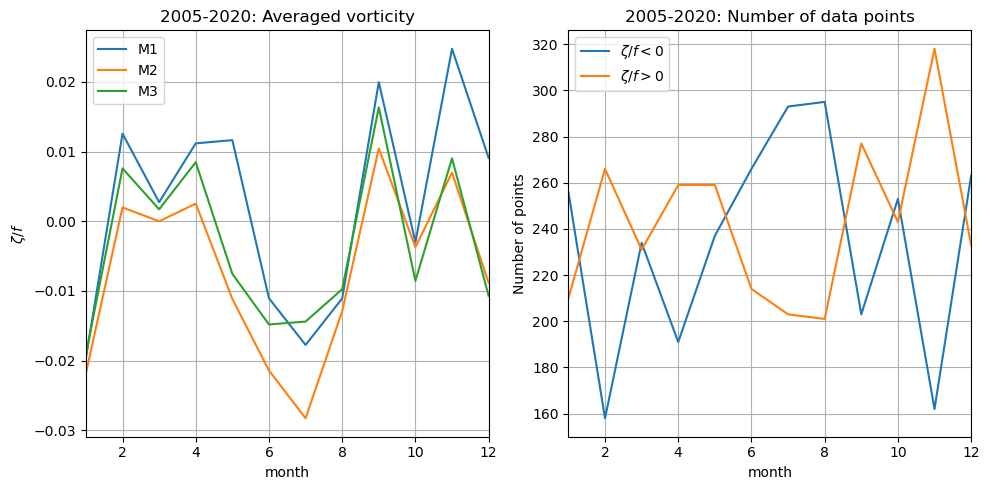

In [9]:
#Comparing seasonal variability of vorticity: averaged value and sign repartition

fig,axs=plt.subplots(1,2,figsize=(10,5),sharey=False)
ax=axs[0]
vort_M1.groupby('time.month').mean().plot(ax=ax,label='M1')
vort_M2.groupby('time.month').mean().plot(ax=ax,label='M2')
vort_M3.groupby('time.month').mean().plot(ax=ax,label='M3')
ax.set_title('2005-2020: Averaged vorticity')
ax=axs[1]
(vort_M1.where(vort_M1<0).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f<0$')
(vort_M1.where(vort_M1>0).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f>0$')
ax.set_title('2005-2020: Number of data points');ax.set_ylabel('Number of points')
for ax in axs:
    ax.grid();ax.legend()
    ax.set_xlim(1,12);
fig.tight_layout()

Notes: Over 14 years, the time-averaged vorticity follows the same monthly evolution for all moorings, with some differences of amplitude. Mean value at M2 is lower than at M1 and M3. This negative bias is expected as M2 is, in average, in a more anticyclonic area. For this time period, only January, and December for M2 and M3 have negative mean vorticity. The main time period of anticyclonic circulation is Summer (May to August). The dominantly anticyclonic circulation during these periods is confirmed by the number of days during which vorticity is negative (right panel).

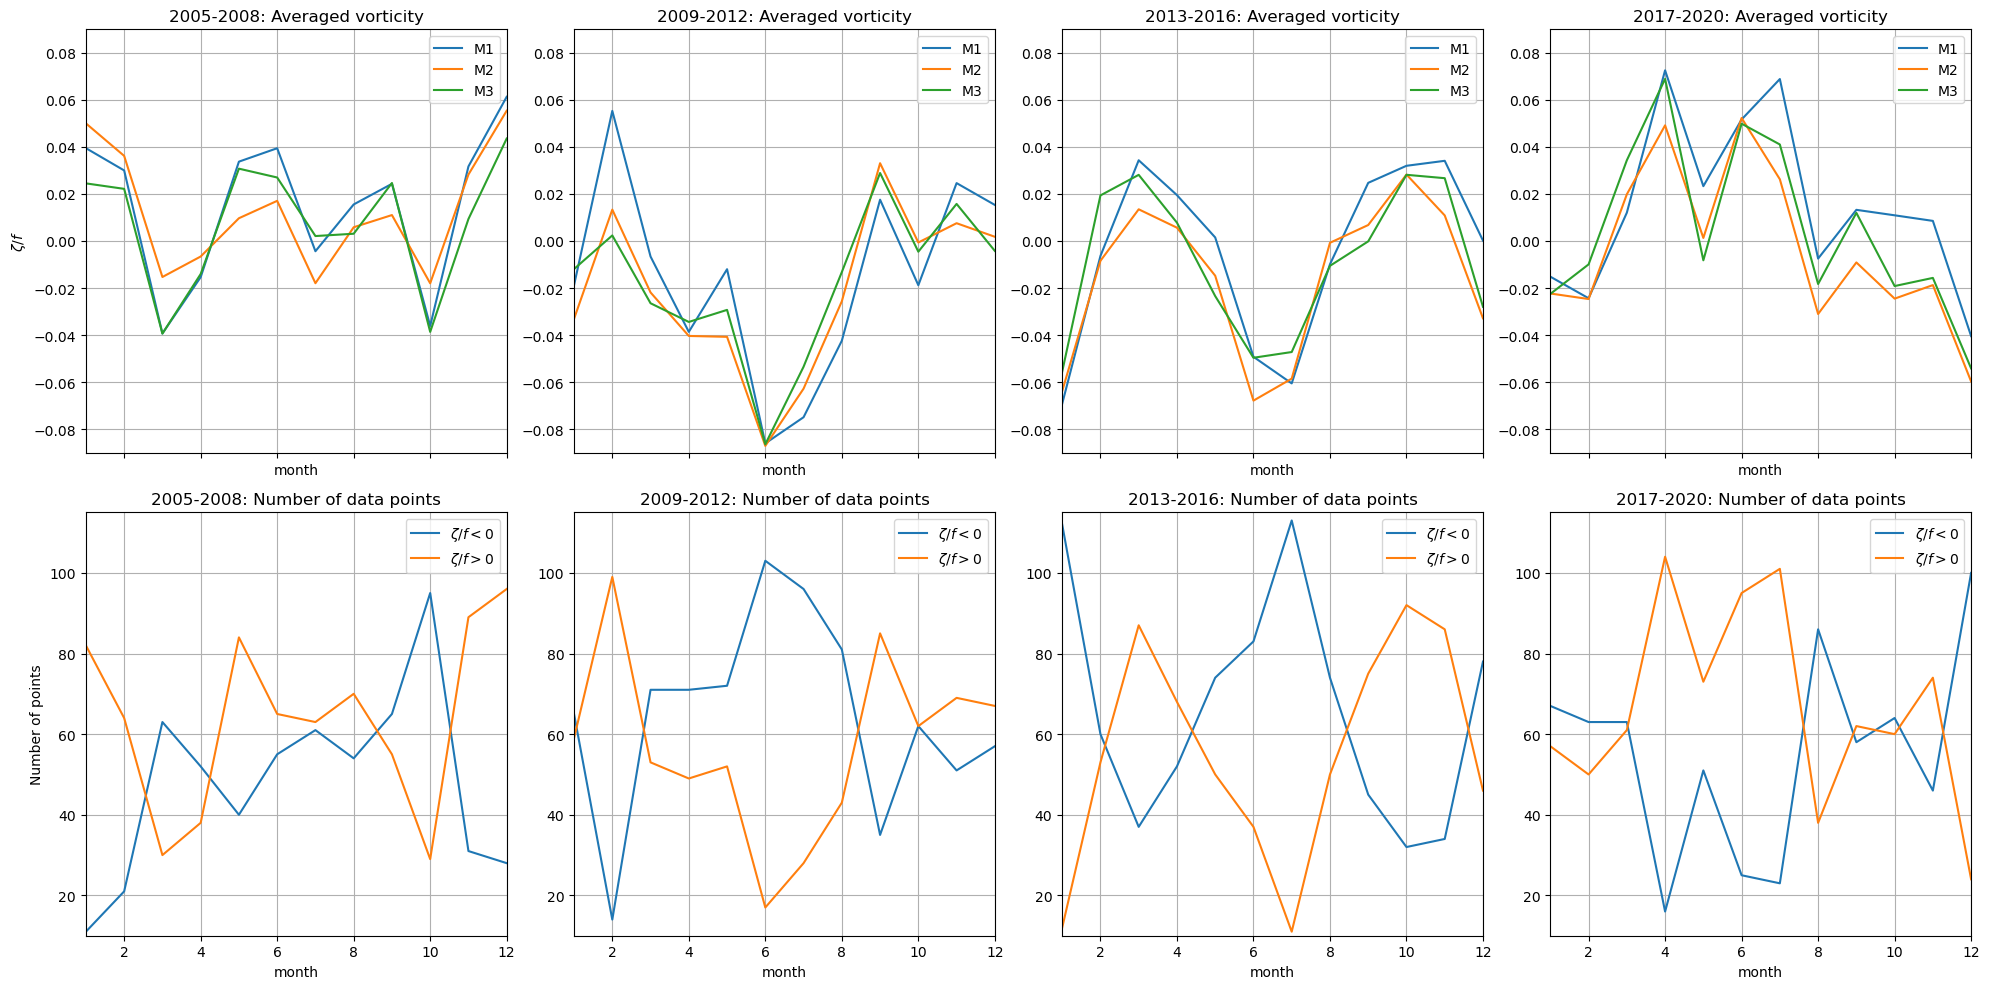

In [51]:
#Comparing seasonal variability of vorticity: averaged value and sign repartition

fig,axs=plt.subplots(2,4,figsize=(20,10),sharey=False,sharex=True)
ax=axs[0,0]
vort_M1.sel(time=slice('2005','2008')).groupby('time.month').mean().plot(ax=ax,label='M1')
vort_M2.sel(time=slice('2005','2008')).groupby('time.month').mean().plot(ax=ax,label='M2')
vort_M3.sel(time=slice('2005','2008')).groupby('time.month').mean().plot(ax=ax,label='M3',ylim=(-0.09,0.09))
ax.set_title('2005-2008: Averaged vorticity')
ax=axs[0,1]
vort_M1.sel(time=slice('2009','2012')).groupby('time.month').mean().plot(ax=ax,label='M1')
vort_M2.sel(time=slice('2009','2012')).groupby('time.month').mean().plot(ax=ax,label='M2')
vort_M3.sel(time=slice('2009','2012')).groupby('time.month').mean().plot(ax=ax,label='M3',ylim=(-0.09,0.09))
ax.set_title('2009-2012: Averaged vorticity');ax.set_ylabel('')
ax=axs[0,2]
vort_M1.sel(time=slice('2013','2016')).groupby('time.month').mean().plot(ax=ax,label='M1')
vort_M2.sel(time=slice('2013','2016')).groupby('time.month').mean().plot(ax=ax,label='M2')
vort_M3.sel(time=slice('2013','2016')).groupby('time.month').mean().plot(ax=ax,label='M3',ylim=(-0.09,0.09))
ax.set_title('2013-2016: Averaged vorticity');ax.set_ylabel('')
ax=axs[0,3]
vort_M1.sel(time=slice('2017','2020')).groupby('time.month').mean().plot(ax=ax,label='M1')
vort_M2.sel(time=slice('2017','2020')).groupby('time.month').mean().plot(ax=ax,label='M2')
vort_M3.sel(time=slice('2017','2020')).groupby('time.month').mean().plot(ax=ax,label='M3',ylim=(-0.09,0.09))
ax.set_title('2017-2020: Averaged vorticity');ax.set_ylabel('')
for ax in axs[0,:]:
    ax.grid();ax.legend()
    ax.set_xlim(1,12);
fig.tight_layout()

#fig,axs=plt.subplots(1,4,figsize=(20,5),sharey=True)
ax=axs[1,0]
(vort_M1.where(vort_M1<0).sel(time=slice('2005','2008')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f<0$')
(vort_M1.where(vort_M1>0).sel(time=slice('2005','2008')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f>0$',ylim=(10,115))
ax.set_title('2005-2008: Number of data points');ax.set_ylabel('Number of points')
ax=axs[1,1]
(vort_M1.where(vort_M1<0).sel(time=slice('2009','2012')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f<0$')
(vort_M1.where(vort_M1>0).sel(time=slice('2009','2012')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f>0$',ylim=(10,115))
ax.set_title('2009-2012: Number of data points');ax.set_ylabel('')
ax=axs[1,2]
(vort_M1.where(vort_M1<0).sel(time=slice('2013','2016')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f<0$')
(vort_M1.where(vort_M1>0).sel(time=slice('2013','2016')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f>0$',ylim=(10,115))
ax.set_title('2013-2016: Number of data points');ax.set_ylabel('')
ax=axs[1,3]
(vort_M1.where(vort_M1<0).sel(time=slice('2017','2020')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f<0$')
(vort_M1.where(vort_M1>0).sel(time=slice('2017','2020')).groupby('time.month').count()).plot(ax=ax,label=r'$\zeta/f>0$',ylim=(10,115))
ax.set_title('2017-2020: Number of data points');ax.set_ylabel('')
for ax in axs[1,:]:
    ax.grid();ax.legend()
    ax.set_xlim(1,12);
fig.tight_layout()
plt.savefig('eke_evolution.png')

__Notes:__ Averaging vorticity over shorter time periods (3 years in this case) highlights different patterns. The seasonal evolution of both mean value and number of days of anticyclonic/cyclonic circulation varies with time. The first years of data (2005 to 2008) don't show a strong seasonal variability, the only consistent pattern seemingly being cyclones dominating the area during winter (December to February). 

The following two 3-years periods (2009 to 2012 and 2013 to 2016) are similar to each other. Both highlight the presence of anticylones during late spring and summer (May to August). The main difference between both periods occurs during winter months. Both present negative vorticity with an higher mean amplitude durin the 2013-2016 period. The number of days of anticyclonic circulation is also smaller during the 2009 to 2012 period compared to the following 3 years.

Finally the most recent period, 2017 to 2020, present an opposite circulation during summer, with averaged positive values and cyclones being present at the mooring for a longer period of time. Anticyclones, however, continue to dominate in winter.

__Conclusions:__
The seasonal evolution of relative vorticity at the moorings site seems to be modulated by longer timescale evolution. This is most likely linked to previous studies on the formation and strucutre of eddies in Iceland Basin (Zhao et al, 2018; Read and Pollard, 2001;Martin et al, 1998; Harris et al, 1997). The main hypothesis supported by these studies is the formation of anticyclones is due to baroclinic instabilities casused by the NAC flowing along the Rockall-Hatton Plateau slope. Martin et al 1998 reported that the course of the NAC in the Iceland Basin is not constant in time and could explain the difference we observed here in the evolution of eddies vorticity.

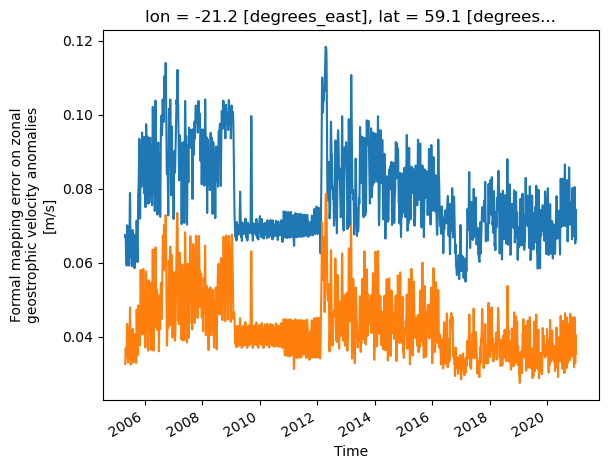

In [91]:
#Estimated error on surface velocity fields from altimetry (provided by CMEMS)
alt.err_vgosa.interp(lon=m1lon,lat=m1lat).plot()
alt.err_ugosa.interp(lon=m1lon,lat=m1lat).plot()

Notes: the evolution with time of error on velocity estimates cannot explain the differences we observe

Text(0.5, 1.0, 'Year: 2010')

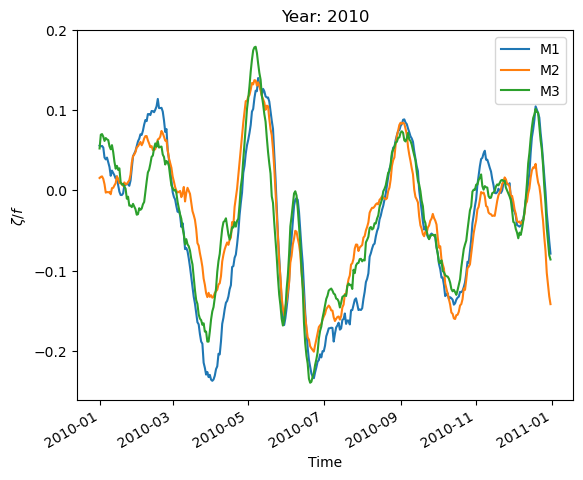

In [124]:
#Test: Zooming on vorticity for one specific year
year='2010'
vort_M1.sel(time=year).plot(label='M1')
vort_M2.sel(time=year).plot(label='M2')
vort_M3.sel(time=year).plot(label='M3')

plt.legend();plt.title('Year: '+year)

### Visualising EKE and vorticity over the NISKINe time period

In [9]:
import cartopy.crs as ccrs

In [8]:
from datetime import datetime
_time = vort.time
v0=0.25

In [125]:
#interpolate vorticity and EKE at moorings coordinates
m1vort = vort.interp(lon=m1lon, lat=m1lat)
m1eke = alt.eke.interp(lon=m1lon, lat=m1lat)

m2vort = vort.interp(lon=m2lon, lat=m2lat)
m2eke = alt.eke.interp(lon=m2lon, lat=m2lat)

m3vort = vort.interp(lon=m3lon, lat=m3lat)
m3eke = alt.eke.interp(lon=m3lon, lat=m3lat)

In [128]:
#Center coordinates
d = 2 * (m1lon * (m2lat - m3lat) + m2lon * (m3lat - m1lat) + m3lon * (m1lat - m2lat))
midlon = ((m1lon * m1lon + m1lat * m1lat) * (m2lat - m3lat) + (m2lon * m2lon + m2lat * m2lat) * (m3lat - m1lat) + (m3lon * m3lon + m3lat * m3lat) * (m1lat - m2lat)) / d
midlat = ((m1lon * m1lon + m1lat * m1lat) * (m3lon - m2lon) + (m2lon * m2lon + m2lat * m2lat) * (m1lon - m3lon) + (m3lon * m3lon + m3lat * m3lat) * (m2lon - m1lon)) / d


Text(-21.297115194422187, 59.03211961693145, 'C')

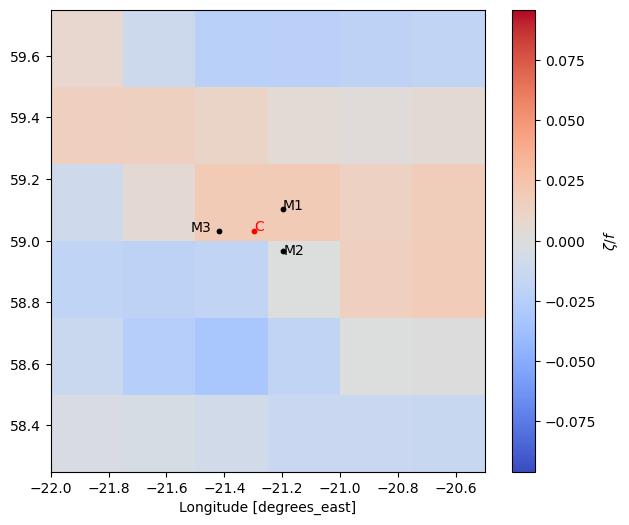

In [15]:
fig,ax = plt.subplots(figsize=(7,6))
vort.mean('time').plot(ax=ax,cmap='coolwarm',cbar_kwargs={'label':r'$\zeta /f $'})
ax.set_xlim((-22),(-20.5))
ax.set_ylim((58.25),(59.75))
ax.scatter(m1lon,m1lat,s=10,c='k');
ax.scatter(midlon,midlat,s=10,c='r');
ax.scatter(m2lon,m2lat,s=10,c='k');ax.scatter(m3lon,m3lat,s=10,c='k')
ax.set_ylabel('');axins.set_xlabel('')
ax.text(m1lon,m1lat,'M1');ax.text(m2lon,m2lat-0.01,'M2');ax.text(m3lon-0.1,m3lat,'M3')
ax.text(midlon,midlat,'C',c='r')

In [129]:
#Interpolate variables at the center of the moorings
midvort = vort.interp(lon=midlon, lat=midlat)
mideke = alt.eke.interp(lon=midlon, lat=midlat)

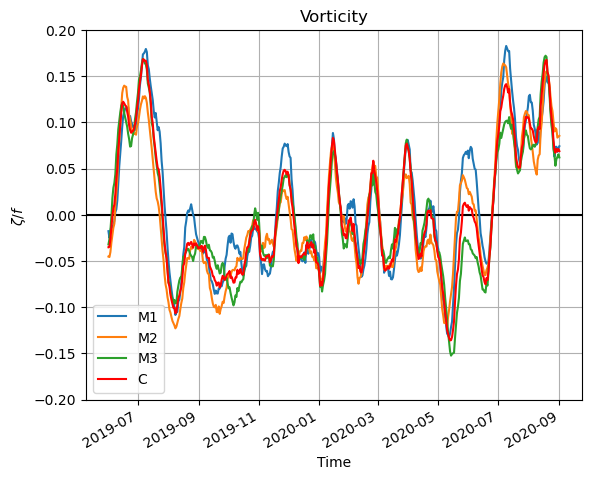

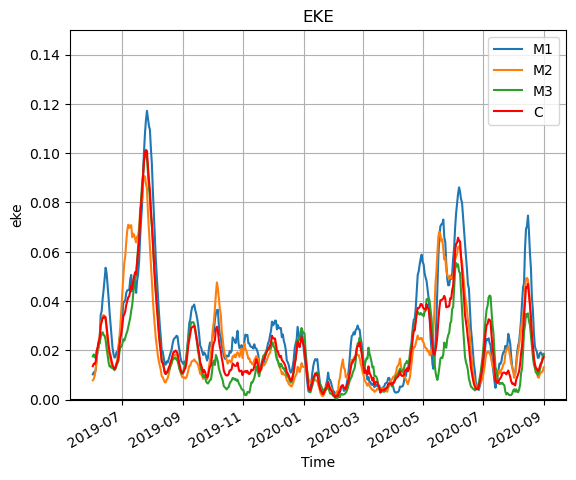

In [17]:
#Plot relative vorticity and EKE at time period of interest at moorings location and at the center of the moorings
plt.axhline(0,c='k')
m1vort.sel(time=slice('2019-06-01','2020-09-01')).plot(label='M1')
m2vort.sel(time=slice('2019-06-01','2020-09-01')).plot(label='M2')
m3vort.sel(time=slice('2019-06-01','2020-09-01')).plot(label='M3')
midvort.sel(time=slice('2019-06-01','2020-09-01')).plot(c='r',label='C')
#m1eke.sel(time=slice('2019-06-01','2020-09-01')).plot()
plt.grid();plt.legend();plt.title('Vorticity');plt.ylim(-0.2,0.2);

plt.figure()
plt.axhline(0,c='k')
m1eke.sel(time=slice('2019-06-01','2020-09-01')).plot(label='M1')
m2eke.sel(time=slice('2019-06-01','2020-09-01')).plot(label='M2')
m3eke.sel(time=slice('2019-06-01','2020-09-01')).plot(label='M3')
mideke.sel(time=slice('2019-06-01','2020-09-01')).plot(c='r',label='C')
#m1eke.sel(time=slice('2019-06-01','2020-09-01')).plot()
plt.grid();plt.legend();plt.title('EKE');plt.ylim(0,0.15);

### Relative vorticity from the moorings

In [12]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

#### Computing vorticity using Lien and Müller method

In [13]:
#Loading and merging moorings data
moorings={}
for mooring in [1,2,3]:
    #gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
    gridded = xr.open_dataset(root_dir+'M%s_lpfiltered.nc'%mooring)#.interpolate_na(dim='time',method='cubic',max_gap=pd.Timedelta(3, "d"))
    ds = gridded[['u','v','u_filtered','v_filtered']]#.expand_dims({'lat':[lat],'lon':[lon]}) #sp.wrap_filter(gridded,h,**{'hilbert':False})
    mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
    ds['mld'] = mld_m1
    moorings[str(mooring)] = ds

In [14]:
#Removing depth range that is not covered by M3
for mooring in moorings:
    moorings[mooring] = moorings[mooring].where(np.isnan(moorings['3'].u)==False)

In [15]:
#Removing depth range that is not covered by M2
for mooring in moorings:
    moorings[mooring] = moorings[mooring].where((np.isnan(moorings['2'].u)==False)&(moorings['2'].count('time')>1000))

In [16]:
R = gsw.distance([m1lon,m2lon],[m1lat,m2lat])/(2*np.sin(60*np.pi/180)) #Distance between the moorings [m]
#15*1e3/np.sqrt(3)
dt = 1/(24*6)  # Time step in days unit

fc = ut.coriolis(midlat) # Coriolis frequency
RV = 2/3/R*((moorings['2'].v_filtered+moorings['1'].v_filtered
            )/2-moorings['3'].v_filtered)-1/np.sqrt(3)/R*(moorings['1'].u_filtered-moorings['2'].u_filtered) #relative vorticity
RV = RV.interpolate_na('time',max_gap=pd.Timedelta(24, "h")) #Interpolating data over gaps (due to flagged profiles) of less than 1day
RV_mean = RV.rolling(time=int(6/dt)).mean() #smoothed relative vorticity

#### Visualising 2D relative vorticity

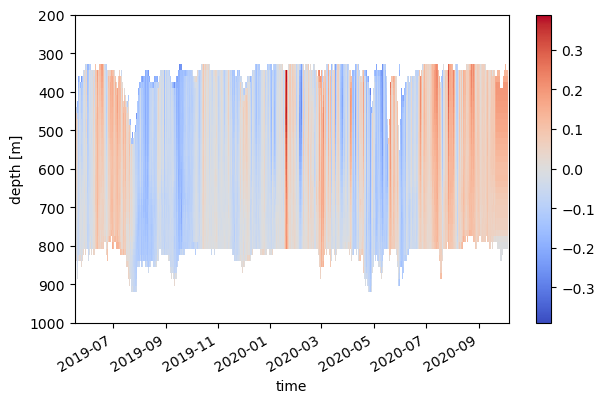

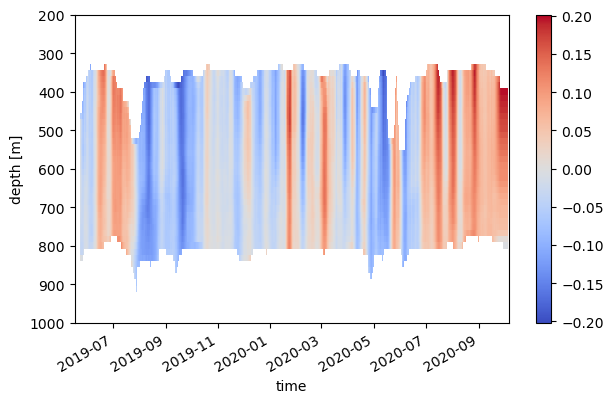

In [40]:
plt.figure(figsize=(7,4))
(RV/fc).plot(yincrease=False, cmap='coolwarm',ylim=(1000,200))

plt.figure(figsize=(7,4))
(RV_mean/fc).plot(yincrease=False, cmap='coolwarm',ylim=(1000,200))

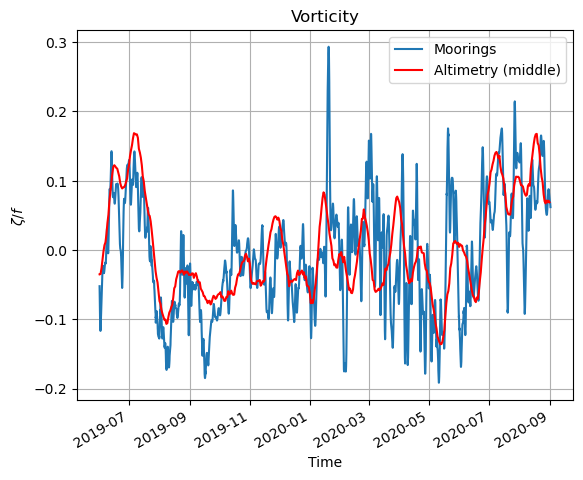

In [17]:
#Comparison beetween depth-averaged (moorings) and surfance (altimetry) vorticity at the center of moorings site
(RV/fc).mean('z').sel(time=slice('2019-06-01','2020-09-01')).plot(label='Moorings')
midvort.sel(time=slice('2019-06-01','2020-09-01')).plot(c='r',label='Altimetry (middle)')
plt.grid();plt.title('Vorticity');plt.legend()

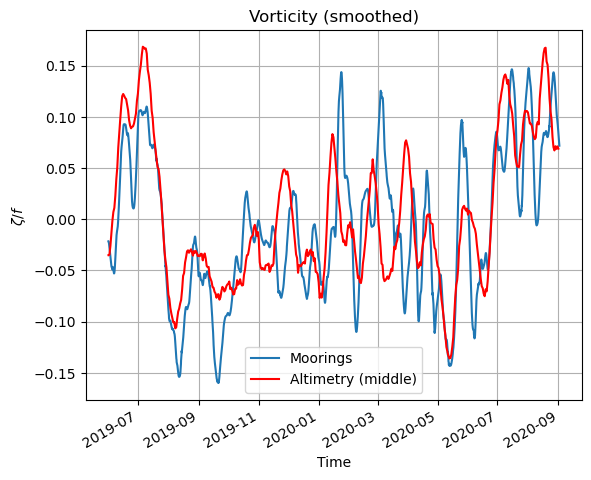

In [19]:
#Sommothe time series
(RV_mean/fc).mean('z').sel(time=slice('2019-06-01','2020-09-01')).plot(label='Moorings')
midvort.sel(time=slice('2019-06-01','2020-09-01')).plot(c='r',label='Altimetry (middle)')
plt.grid();plt.title('Vorticity (smoothed)');plt.legend()



In [24]:
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [34]:
# Wind
wind_work = xr.open_dataset(root_dir+'ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'wind_work/wind_stress_niskine_m1.nc')

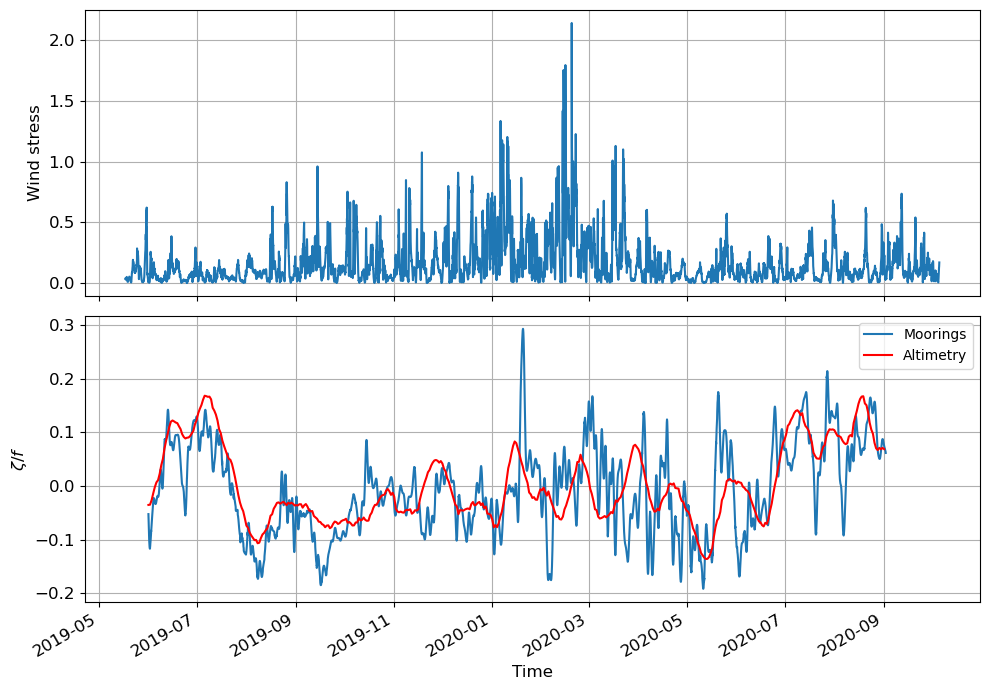

In [42]:
fig,axs = plt.subplots(2,1,figsize=(10,7),sharex=True)
ax = axs[0]
wind_stress['__xarray_dataarray_variable__'].plot(ax=ax)
ax.grid();ax.set_title('');ax.set_ylabel('Wind stress')
ax = axs[1]
(RV/fc).mean('z').sel(time=slice('2019-06-01','2020-09-01')).plot(ax=ax,label='Moorings')
midvort.sel(time=slice('2019-06-01','2020-09-01')).plot(ax=ax,c='r',label='Altimetry')
ax.grid();ax.set_title('');ax.legend()
fig.tight_layout()
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/wind_vort.jpg')

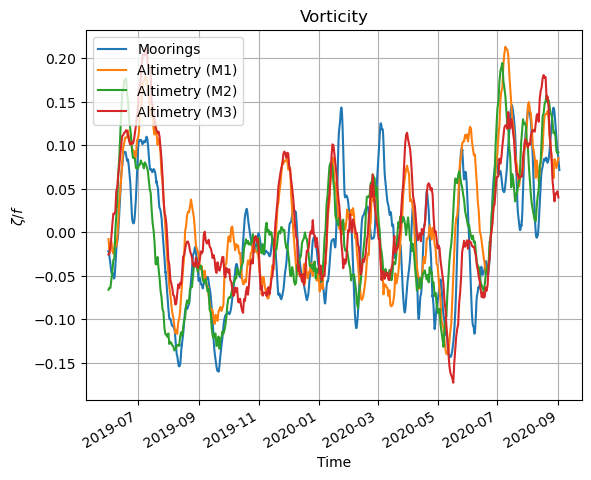

In [48]:
(RV_mean/fc).mean('z').sel(time=slice('2019-06-01','2020-09-01')).plot(label='Moorings')
vort.sel(lon=m1lon,lat=m1lat,method='nearest').sel(time=slice('2019-06-01','2020-09-01')).plot(label='Altimetry (M1)')
vort.sel(lon=m2lon,lat=m2lat,method='nearest').sel(time=slice('2019-06-01','2020-09-01')).plot(label='Altimetry (M2)')
vort.sel(lon=m3lon,lat=m3lat,method='nearest').sel(time=slice('2019-06-01','2020-09-01')).plot(label='Altimetry (M3)')
plt.grid();plt.title('Vorticity');plt.legend()

#### Saving dataset

In [88]:
#Creating vorticity xarray dataset
ds = xr.Dataset({'vorticity':RV,'vorticity_norm':RV/fc,'vorticity_z':RV.differentiate('z')})

In [89]:
ds['vorticity'] = ds.vorticity.assign_attrs(units=r'$s^{-1}$',long_name=r'$\zeta$')
ds['vorticity_norm'] = ds.vorticity_norm.assign_attrs(units='',long_name=r'$\zeta / f $')
ds['vorticity_z'] = ds.vorticity_z.assign_attrs(units=r'$(m.s)^{-1}$',long_name=r'$\zeta_z$')

In [92]:
ds.to_netcdf(root_dir+'vorticity_moorings.nc')#saving moorings vorticity

In [87]:
vort.to_netcdf(root_dir+'vorticity_alt.nc') #saving altimetry vorticity